In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# !cp /content/drive/My\ Drive/Datasets/digit-recognizer.zip /content/
# !unzip digit-recognizer.zip
# !rm -rf digit-recognizer.zip

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X, y = train_df.drop(['label'], axis = 1), train_df['label']

In [0]:
# Normalize the data
X = X.to_numpy(dtype=np.float32) / 255.0
y = y.to_numpy(dtype=np.float32)
#one hot encoding
y = pd.get_dummies(y).to_numpy()

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 28)
print (f'X_train shape: {X_train.shape}')
print (f'X_valid shape: {X_valid.shape}')
print (f'y_train shape: {y_train.shape}')
print (f'y_valid shape: {y_valid.shape}')

X_train shape: (37800, 784)
X_valid shape: (4200, 784)
y_train shape: (37800, 10)
y_valid shape: (4200, 10)


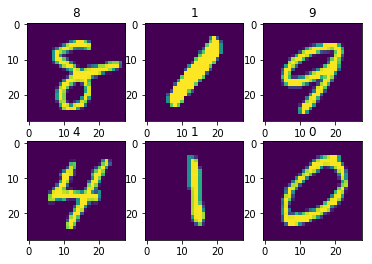

In [0]:
fig, axis = plt.subplots(nrows=2, ncols=3)
count = 0
for row in axis:
    for col in row:
        col.imshow(X_train[count, :].reshape(28, 28))
        col.set_title(np.argmax(y_train[count]))
        count += 1

plt.show()

In [0]:
def initialize_params(input_size, hidden_layers, n_classes):

    # tf.reset_default_graph()
    params = {}
    hidden_layers.insert(0, input_size)
    hidden_layers.append(n_classes)

    for layer in range(len(hidden_layers) - 1):
        params[layer] = {}
        params[layer][f'W{layer}'] = tf.get_variable(name = f'W{layer}', shape = [hidden_layers[layer + 1], hidden_layers[layer]], initializer = tf.contrib.layers.xavier_initializer(seed=28))
        params[layer][f'b{layer}'] = tf.get_variable(name = f'b{layer}', shape = [hidden_layers[layer + 1], 1], initializer = tf.zeros_initializer())
    
    return params


In [0]:
def forward_propagate(X, params):

    A_prev = tf.transpose(X)

    for layer, param in params.items():
        Z = tf.add(tf.matmul(param[f'W{layer}'], A_prev), param[f'b{layer}'])
        A = tf.nn.relu(Z)
        A_prev = A
    return Z # Z is needed to calculate cost

In [0]:
def calculate_cost(y, y_pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = tf.transpose(y_pred)))

In [0]:
def create_placeholders(input_size):
    X = tf.placeholder(name='X', shape=[None, input_size], dtype=tf.float32)
    y = tf.placeholder(name='Y', shape=[None, 10], dtype=tf.float32)

    return X, y

In [0]:
def predict(X, params):
    Z_L = forward_propagate(X, params)
    with tf.Session() as session:
        preds = session.run(Z_L)
        return np.argmax(session.run(Z_L), axis = 0)

In [0]:
def model (X_train, y_train, X_test, y_test, learning_rate = 0.01, epochs = 1500):

    tf.reset_default_graph()
    n_classes = 10 # 0 - 9 digits are classes
    params = initialize_params(X_train.shape[1], [32, 32, 32], 10)
    X, y = create_placeholders(X_train.shape[1])
    costs = []

    # Forward propagate
    Z_L = forward_propagate(X, params)
    cost = calculate_cost(y, Z_L)

    # Back propagate
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as session:
        session.run(init)
        for epoch in range(epochs + 1):
            _, batch_cost = session.run([optimizer, cost], feed_dict = {X: X_train, y: y_train})
            if epoch % 5 == 0:
                costs.append(batch_cost)
            if epoch % 100 == 0:
                print (f'Costs after {epoch} epochs: {batch_cost}')
    
        params = session.run(params)

        x1 = tf.placeholder(name = 'x1', shape = [None, 784], dtype = tf.float32)
        y1 = tf.placeholder(name = 'y1', shape = [None, 10], dtype = tf.float32)
        
        correct_preds = tf.equal(tf.argmax(tf.transpose(forward_propagate(x1, params)), axis = 1), tf.argmax(y1, axis = 1))
        accuracy = tf.reduce_mean(tf.cast(correct_preds, dtype= 'float'))

        train_acc = session.run(accuracy, feed_dict = {x1: X_train, y1: y_train})
        test_acc = session.run(accuracy, feed_dict = {x1: X_test, y1: y_test})

        print (f'Training set Accuracy: {train_acc * 100}')
        print (f'Dev set Accuracy: {test_acc * 100}')

        return params, costs

In [0]:
params, costs = model(X_train=X_train, y_train = y_train, X_test=X_valid, y_test=y_valid, learning_rate=0.02, epochs = 1500)

Costs after 0 epochs: 2.3272762298583984
Costs after 100 epochs: 0.06947113573551178
Costs after 200 epochs: 0.12026707082986832
Costs after 300 epochs: 0.03401559218764305
Costs after 400 epochs: 0.01476543489843607
Costs after 500 epochs: 0.005949029698967934
Costs after 600 epochs: 0.0023656003177165985
Costs after 700 epochs: 0.0012101848842576146
Costs after 800 epochs: 0.0007004813523963094
Costs after 900 epochs: 0.00043058476876467466
Costs after 1000 epochs: 0.00030191277619451284
Costs after 1100 epochs: 0.00022347319463733584
Costs after 1200 epochs: 0.00017265166388824582
Costs after 1300 epochs: 0.0001366628857795149


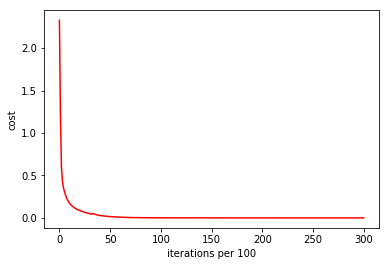

In [0]:
plt.plot(costs, 'r')
plt.xlabel('iterations per 100')
plt.ylabel('cost')
plt.show()

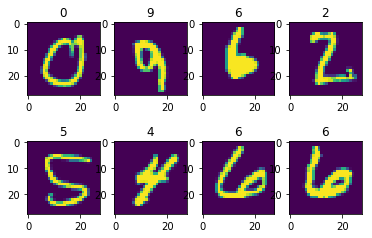

In [0]:
# plot few predictions
fig, axis = plt.subplots(nrows=2, ncols=4)
count = 0
preds = predict(X_valid, params)
for row in axis:
    for col in row:
        col.imshow(X_valid[count, :].reshape(28, 28))
        col.set_title(preds[count])
        count += 1

plt.show()